In [1]:
%cd ..

C:\Users\efurst1\PycharmProjects\LIDC_GDRO


In [99]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
import data_util
import models
import torch
import loss
import train
import pandas as pd
import numpy as np

In [255]:
device = "cuda" if torch.cuda.is_available() else "cpu"

training_fraction = 0.8
batch_size = 160
proportional = True

is_gdro = True

hparams = {"groupdro_eta": 0.03}

In [102]:
subtype_df = pd.read_csv("data/lidc_spic_subgrouped_radiologist.csv")

# import data
df = pd.read_csv("data/LIDC_individual_radiologists.csv")
# preprocess data (normalization, remove anything that isn't in the chosen features)
df = data_util.preprocess_data(df, subtype_df)

In [103]:
sum(df["malignancy"] == 0) / len(df)

0.6133909287257019

In [104]:
# get train/test flags
train_test = pd.read_csv("data/lidc_train_test_radiologist.csv")

# create train/test dataframes
training_df = df[df["noduleID"].isin(train_test[train_test["dataset"] == "train"]["noduleID"].values)]
test_df = df[df["noduleID"].isin(train_test[train_test["dataset"] == "test"]["noduleID"].values)]

# use noduleIDs as index, it makes things easier
subtype_df.index = subtype_df["noduleID"].values


# Test convergence of combinations of ERM and GDRO

In [249]:
N = 10
epochs = 20
subtypes = ["Overall", "Unspiculated benign", "Spiculated benign", "Spiculated malignant", "Unspiculated malignant"]

# test_algorithms = ["ERM", "GDRO", "Sharp", "Smooth", "ReverseSmooth", "Adaptive", "ExtraERM", "ExtraGDRO", "Halfway"]
# test_algorithms = ["Mix" + str(t) for t in [0.4, 0.5, 0.6, 0.7, 0.8]]
test_algorithms = ["ERM", "GDRO0.02", "GDRO0.03", "GDRO0.04", "GDRO0.05"]

results = {algorithm: np.zeros(N * epochs * len(subtypes)) for algorithm in test_algorithms}
for algorithm in test_algorithms:

    print("Running test: " + algorithm)

    # create the training and testing dataloaders
#     if algorithm == "ERM":
#         train_dataloader = data_util.create_dataloader(training_df, batch_size)
#     else:
#         train_dataloader = data_util.create_subtyped_dataloader(training_df, subtype_df, batch_size, proportional)
#     test_dataloader = data_util.create_subtyped_dataloader(test_df, subtype_df, batch_size, proportional)
    
    train_dataloader = data_util.create_dataloader(training_df, batch_size)
    test_dataloader = data_util.create_dataloader(test_df, batch_size)

    for n in range(N):

        print(f"Trial {n + 1}/{N}")

        # create and train model
        model = models.NeuralNetwork(64, 32, 32, 2)
        model.to(device)

        if (algorithm == "ERM"):
            loss_fn = loss.ERMLoss(model, torch.nn.CrossEntropyLoss(), hparams, subclassed=True)
        elif (algorithm == "GDRO"):
            loss_fn = loss.GDROLossAlt(model, torch.nn.CrossEntropyLoss(), hparams["groupdro_eta"], 4, normalize_loss=True)
        else:
            loss_fn = loss.ERMGDROLoss(model, torch.nn.CrossEntropyLoss(), hparams, 4, normalize_loss=True, subclassed=True)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.005)

        for epoch in range(epochs):
            if algorithm == "Sharp":
                loss_fn.t = epoch / epochs < 0.5  # sharp boundary
            elif algorithm == "Smooth":
                loss_fn.t = 1 - (epoch / (epochs - 1))  # linear interpolation
            elif algorithm == "ReverseSmooth":
                loss_fn.t = epoch / (epochs - 1)  # reverse linear interpolation
            elif algorithm == "Adaptive":
                acc = train.test(test_dataloader, model)[0]
                loss_fn.t = acc < 0.85  # use gdro when overall accuracy is above threshold
            elif algorithm == "ExtraERM":
                loss_fn.t = 2
            elif algorithm == "ExtraGDRO":
                loss_fn.t = -1
            elif algorithm == "Halfway":
                loss_fn.t = 0.5
            elif algorithm.startswith("Mix"):
                loss_fn.t = float(algorithm[3:])  # ex. algorithm == "Mix0.5" => t = 0.5

            train.train(train_dataloader, model, loss_fn, optimizer)
            sensitivities = train.test(test_dataloader, model)

            for i in range(len(subtypes)):
                results[algorithm][n * epochs * len(subtypes) + epoch * len(subtypes) + i] = sensitivities[i]

results_df = pd.DataFrame(results, index=pd.MultiIndex.from_product([range(N), range(epochs), subtypes], names=["trial", "epoch", "subtype"]))

print("Test complete")

Running test: ERM
Trial 1/10
Trial 2/10
Trial 3/10
Trial 4/10
Trial 5/10
Trial 6/10
Trial 7/10
Trial 8/10
Trial 9/10
Trial 10/10
Running test: GDRO0.02
Trial 1/10
Trial 2/10
Trial 3/10
Trial 4/10
Trial 5/10
Trial 6/10
Trial 7/10
Trial 8/10
Trial 9/10
Trial 10/10
Running test: GDRO0.03
Trial 1/10
Trial 2/10
Trial 3/10
Trial 4/10
Trial 5/10
Trial 6/10
Trial 7/10
Trial 8/10
Trial 9/10
Trial 10/10
Running test: GDRO0.04
Trial 1/10
Trial 2/10
Trial 3/10
Trial 4/10
Trial 5/10
Trial 6/10
Trial 7/10
Trial 8/10
Trial 9/10
Trial 10/10
Running test: GDRO0.05
Trial 1/10
Trial 2/10
Trial 3/10
Trial 4/10
Trial 5/10
Trial 6/10
Trial 7/10
Trial 8/10
Trial 9/10
Trial 10/10
Test complete


In [250]:
trial_means = results_df.unstack().unstack().median().unstack(level=0).unstack(level=1).stack()
trial_means

ERM  GDRO0.02  GDRO0.03  GDRO0.04  GDRO0.05
subtype                epoch                                                  
Overall                0      0.790625  0.801875  0.792500  0.781875  0.784375
                       1      0.801875  0.801875  0.800625  0.803125  0.791250
                       2      0.811250  0.818125  0.824375  0.815000  0.811875
                       3      0.821250  0.826250  0.824375  0.820625  0.836250
                       4      0.825000  0.829375  0.830000  0.816875  0.816875
...                                ...       ...       ...       ...       ...
Unspiculated malignant 15     0.688879  0.803847  0.817028  0.817670  0.840574
                       16     0.675236  0.806980  0.820631  0.836790  0.816454
                       17     0.699521  0.807563  0.833293  0.826343  0.839231
                       18     0.675321  0.822231  0.841453  0.855973  0.837067
                       19     0.676716  0.810779  0.862354  0.836320  0.834212

[100 rows x 5 columns]

In [251]:
worst_group = trial_means.unstack(level=1).min().unstack(level=0)
worst_group.index = pd.MultiIndex.from_product([["Worst"], worst_group.index], names=["subtype", "epoch"])
worst_concat = pd.concat([trial_means.unstack(level=1).stack(), worst_group])
worst_concat

ERM  GDRO0.02  GDRO0.03  GDRO0.04  GDRO0.05
subtype epoch                                                  
Overall 0      0.790625  0.801875  0.792500  0.781875  0.784375
        1      0.801875  0.801875  0.800625  0.803125  0.791250
        2      0.811250  0.818125  0.824375  0.815000  0.811875
        3      0.821250  0.826250  0.824375  0.820625  0.836250
        4      0.825000  0.829375  0.830000  0.816875  0.816875
...                 ...       ...       ...       ...       ...
Worst   15     0.688879  0.769861  0.709054  0.777564  0.743852
        16     0.675236  0.773306  0.720217  0.753816  0.714603
        17     0.699521  0.733281  0.775259  0.732864  0.752193
        18     0.675321  0.731111  0.749784  0.725705  0.757646
        19     0.676716  0.791506  0.737217  0.710363  0.696154

[120 rows x 5 columns]

In [252]:
"""
Test parameters

input: 64 engineered features extracted from lidc max-slice images

model layer sizes = (64, 32, 32, 2)
groupdro_eta = 0.1
lr = 0.001
weight_decay = 0.005

batch_size = 40
proportional = True
epochs = 40
N = 120

"""

'\nTest parameters\n\ninput: 64 engineered features extracted from lidc max-slice images\n\nmodel layer sizes = (64, 32, 32, 2)\ngroupdro_eta = 0.1\nlr = 0.001\nweight_decay = 0.005\n\nbatch_size = 40\nproportional = True\nepochs = 40\nN = 120\n\n'

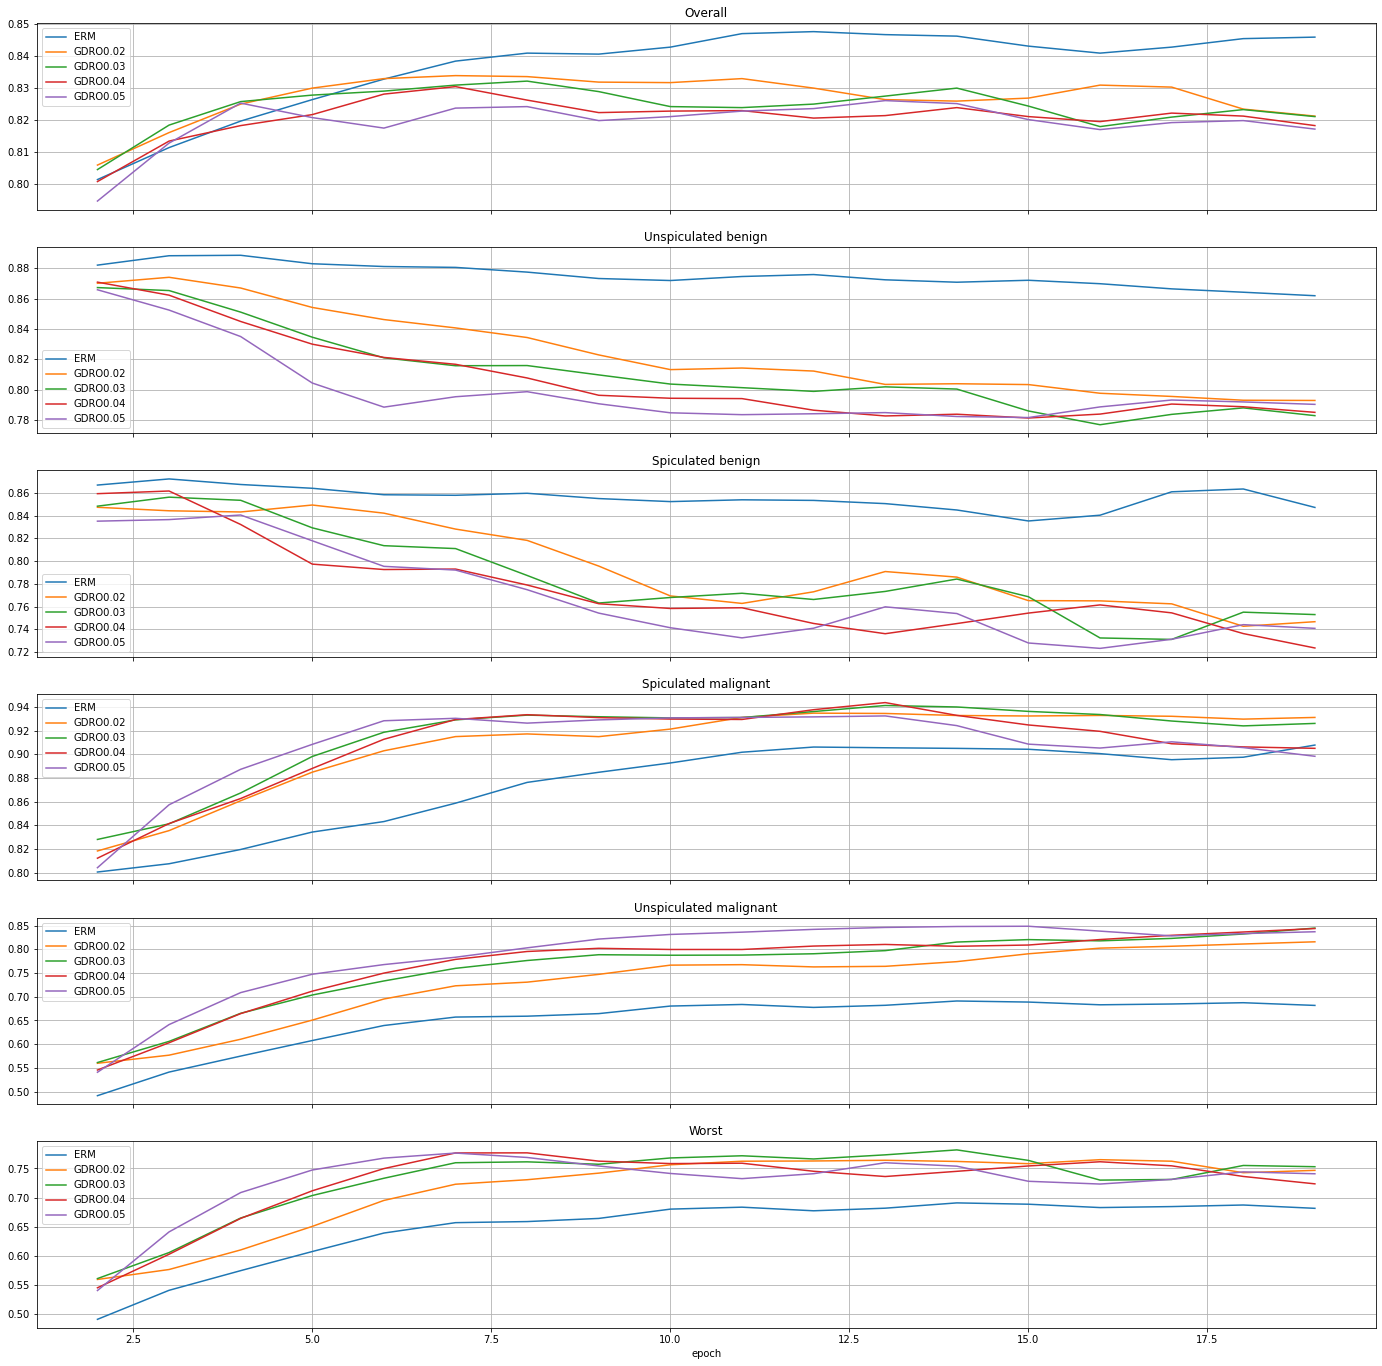

In [254]:
import matplotlib.pyplot as plt

rolling_window = 2

rolling_data = worst_concat.unstack(level=0).rolling(rolling_window).mean().unstack().unstack(level=0)

plots = [*subtypes, "Worst"]

hide = []

f, a = plt.subplots(len(plots),1, sharex = True)
# plot subtypes sensitivity
for i in range(len(plots)):
    rolling_data.drop(columns=hide).rolling(rolling_window).mean().xs(plots[i]).plot(kind='line',title=plots[i],ax=a[i],figsize=(24,24),grid=True)

In [215]:
# data for test_algorithms = ["ERM", "GDRO", "Sharp", "Smooth", "ReverseSmooth", "Adaptive", "ExtraERM", "ExtraGDRO", "Halfway"]
# N = 50, epochs = 20
all_data

ERM      GDRO     Sharp    Smooth  ReverseSmooth  \
subtype epoch                                                          
Overall 0      0.791175  0.794600  0.796000  0.795200       0.799350   
        1      0.813800  0.802875  0.818700  0.815475       0.805350   
        2      0.821025  0.814075  0.819425  0.817875       0.817375   
        3      0.821625  0.812075  0.822275  0.820175       0.829325   
        4      0.829825  0.819725  0.826100  0.824600       0.830925   
...                 ...       ...       ...       ...            ...   
Worst   15     0.675100  0.732846  0.753460  0.735389       0.713223   
        16     0.685194  0.722461  0.735347  0.726454       0.707076   
        17     0.678407  0.738425  0.731847  0.709797       0.706589   
        18     0.682105  0.736175  0.737202  0.697710       0.684052   
        19     0.684803  0.733521  0.712378  0.689144       0.685421   

               Adaptive  ExtraERM  ExtraGDRO   Halfway  
subtype epoch                                           
Overall 0      0.797875  0.796725   0.211975  0.793275  
        1      0.810950  0.814675   0.202700  0.812650  
        2      0.818325  0.822250   0.226925  0.824725  
        3      0.823125  0.825225   0.205675  0.826900  
        4      0.825750  0.831075   0.210875  0.831625  
...                 ...       ...        ...       ...  
Worst   15     0.706351  0.750009   0.354582  0.749469  
        16     0.717552  0.749584   0.240623  0.758230  
        17     0.720562  0.746536   0.155855  0.760911  
        18     0.697140  0.751371   0.140000  0.759874  
        19     0.710979  0.759447   0.100000  0.748907  

[120 rows x 9 columns]

In [ ]:
# old results with flawed malignancy labels + CNN subtypes
data_clean0